<a href="https://colab.research.google.com/github/Dhanushranga1/AIWorks/blob/master/Unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
import zipfile
import shutil
# deep learning libs
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


Unzipping the dataset

In [4]:
zip_path = "/content/drive/MyDrive/kaggle_3m.zip"
extract_path = "/content/kaggle_3m"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("done extracting to:", extract_path)
else:
    print("already extracted, skipping that step")

done extracting to: /content/kaggle_3m


**Organizing the images and masks as taken from the kaggle reference**

we’re looping through each patient folder, checking all .tif files
if it has “_mask” in the name we drop it in the masks/ folder, else it goes to images/
this helps keep things clean before we load stuff into the model

In [5]:
import glob
# fixed path that actually contains the patient folders
extract_path = "/content/kaggle_3m/kaggle_3m"

image_dir = "/content/brain_mri/images"
mask_dir = "/content/brain_mri/masks"

os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# only organize if not already done
if not os.listdir(image_dir) or not os.listdir(mask_dir):
    print("organizing image and mask files...")
    for patient in tqdm(os.listdir(extract_path)):
        folder = os.path.join(extract_path, patient)
        if os.path.isdir(folder):
            tifs = glob.glob(os.path.join(folder, "*.tif"))
            for tif in tifs:
                fname = os.path.basename(tif)
                if "_mask" in fname.lower():
                    shutil.copy(tif, os.path.join(mask_dir, fname))
                else:
                    shutil.copy(tif, os.path.join(image_dir, fname))
    print("done.")
    print("images found:", len(os.listdir(image_dir)))
    print("masks found:", len(os.listdir(mask_dir)))
else:
    print("already organized, skipping this step.")


organizing image and mask files...


100%|██████████| 112/112 [00:06<00:00, 18.47it/s]


done.
images found: 3929
masks found: 3929


**Loading the Dataset and PreProcessing the DataSet**

so first we split all the image and mask paths into train and val using train_test_split

initially, when the image size was 128x128, loading everything into memory worked fine
but after switching to 256x256, colab started crashing because of RAM issues

so we built a custom data generator that loads images and masks batch by batch instead of all at once

this generator takes care of:

    

*   resizing the images and masks to 256x256
* normalizing image values (0–1 range)
* binarizing the masks (making sure it's only 0 or 1)

by doing it this way, we only load what we need during training, so RAM usage stays low
this made training smooth and stopped colab from crashing


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

IMG_SIZE = 256

class MRIDataGenerator(Sequence):
    def __init__(self, img_paths, mask_paths, batch_size=8, shuffle=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.img_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = [], []
        for i in batch_indices:
            img = cv2.imread(self.img_paths[i])
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
            mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
            mask = np.expand_dims((mask > 0.5).astype(np.float32), axis=-1)
            X.append(img)
            Y.append(mask)
        return np.array(X), np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Get image and mask file paths
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.tif")))

img_train, img_val, mask_train, mask_val = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
train_gen = MRIDataGenerator(img_train, mask_train)
val_gen = MRIDataGenerator(img_val, mask_val)# will be used when model training


**Unet Model**

* The encoder gradually reduces image size and extracts features using Conv2D and MaxPooling.

*  The bottleneck connects the encoder and decoder.

*  The decoder upsamples the feature maps and combines them with encoder outputs (skip connections) to retain spatial details.

* The final layer outputs a single-channel mask using a sigmoid activation.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    smooth = 1e-7
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(b)
    b = layers.BatchNormalization()(b)

    # Decoder
    u1 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u1 = layers.Concatenate()([u1, c3])
    u1 = layers.Dropout(0.1)(u1)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Dropout(0.1)(u2)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u3 = layers.Concatenate()([u3, c1])
    u3 = layers.Dropout(0.1)(u3)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    return models.Model(inputs, outputs)

# compile the model
model = unet()
model.compile(optimizer="adam", loss=bce_dice_loss, metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

**Training the Model**

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


392/392 ━━━━━━━━━━━━━━━━━━━━ 225s 448ms/step - accuracy: 0.9059 - loss: 1.3096 - val_accuracy: 0.6875 - val_loss: 5.3123
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.9877 - loss: 0.6676 - val_accuracy: 0.9669 - val_loss: 0.9464
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 163s 415ms/step - accuracy: 0.9897 - loss: 0.6210 - val_accuracy: 0.9899 - val_loss: 0.6928
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.9900 - loss: 0.5984 - val_accuracy: 0.9915 - val_loss: 0.6948
Epoch 5/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.9907 - loss: 0.5810 - val_accuracy: 0.9903 - val_loss: 0.6357
Epoch 6/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.9913 - loss: 0.5739 - val_accuracy: 0.9854 - val_loss: 0.7446
Epoch 7/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.9908 - loss: 0.5542 - val_accuracy: 0.9903 - val_loss: 0.6063
Epoch 8/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 172s 438ms/step - accuracy: 0.9914 - loss: 0.55

**Segmentation Results Visualization**

We’re randomly picking a few batches from the validation generator and getting predictions from the model.
For each selected image, we show the original MRI, its ground truth mask, and the predicted mask side by side.
This helps visually check how well the model is segmenting the brain tumors.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


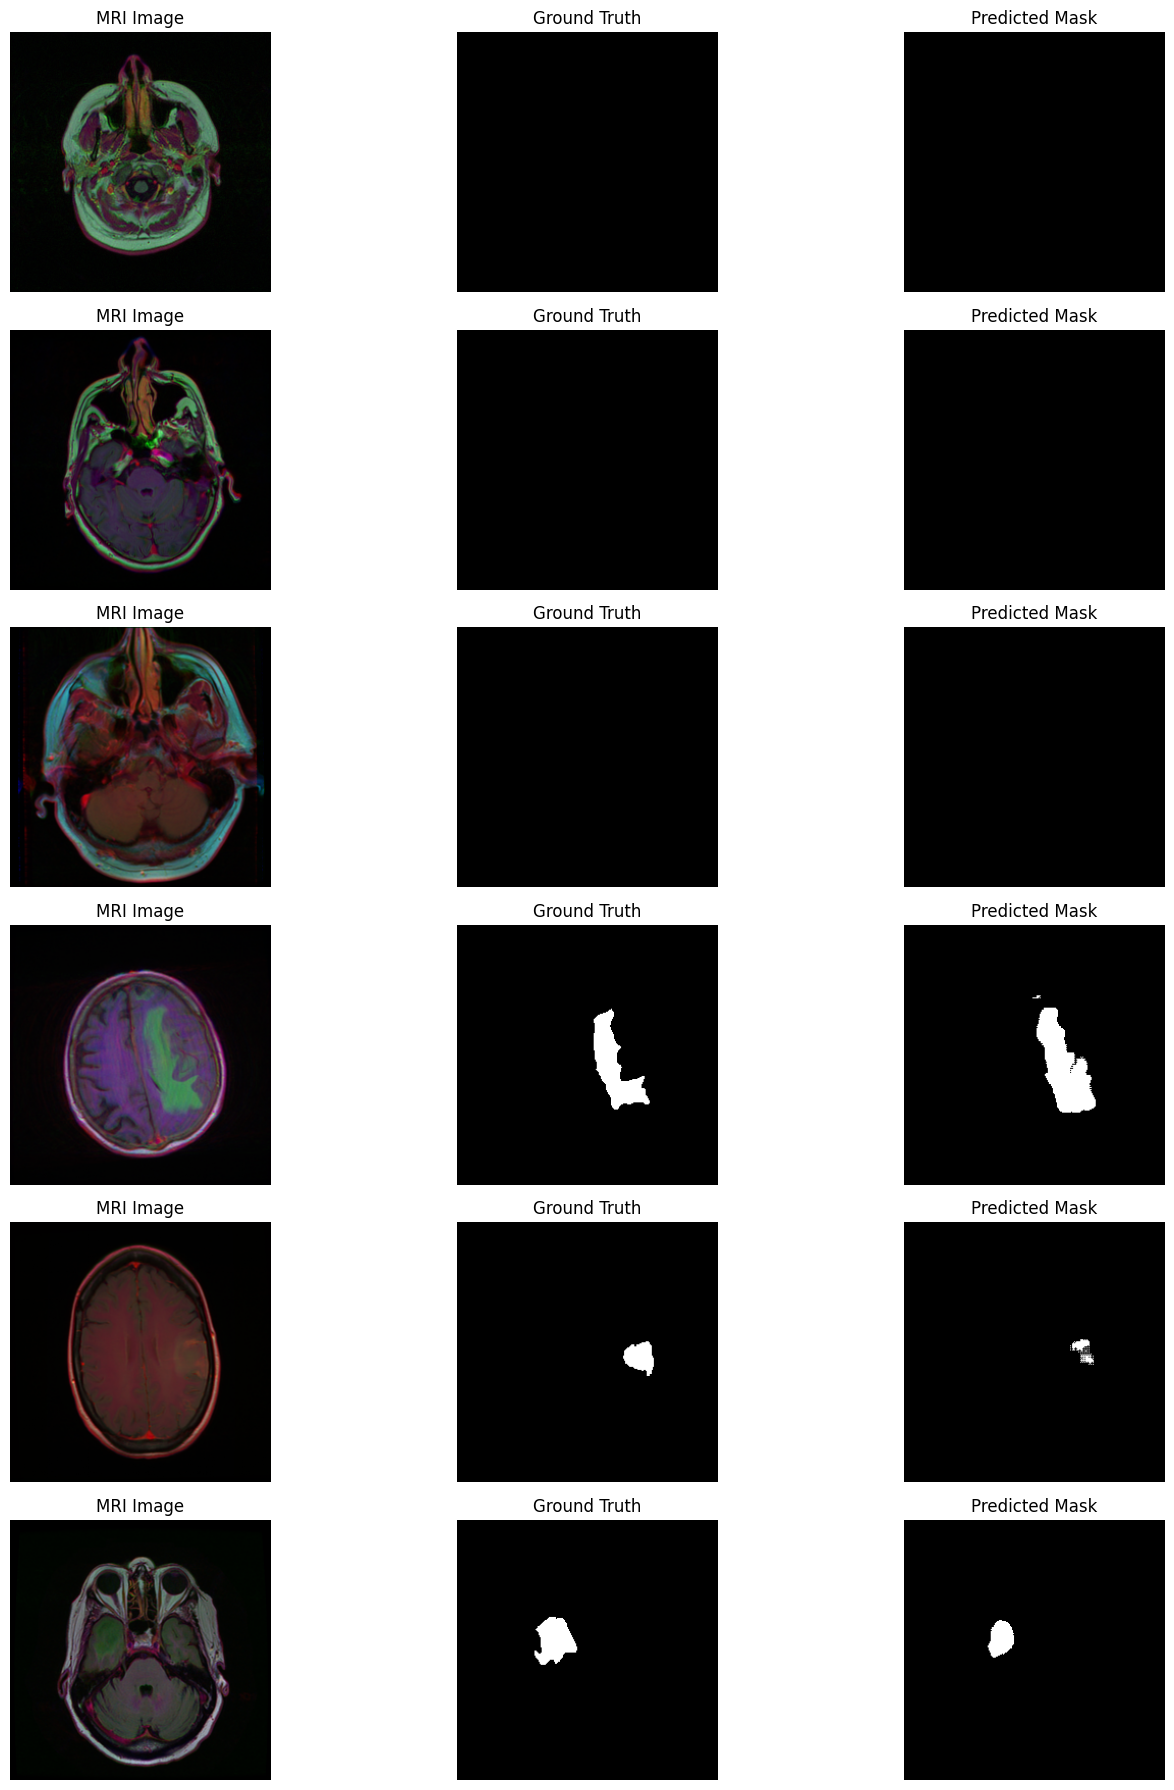

In [24]:
import matplotlib.pyplot as plt
import random

def show_random_predictions(model, val_gen, num_images=6):

    all_indices = list(range(len(val_gen)))
    random.shuffle(all_indices)

    shown = 0
    plt.figure(figsize=(15, num_images * 3))

    for batch_index in all_indices:
        X_batch, Y_batch = val_gen[batch_index]
        preds = model.predict(X_batch)
        preds_bin = (preds > 0.5).astype(np.float32)

        batch_size = len(X_batch)
        for i in range(batch_size):
            if shown >= num_images:
                break

            # MRI Image
            plt.subplot(num_images, 3, shown * 3 + 1)
            plt.imshow(X_batch[i])
            plt.title("MRI Image")
            plt.axis('off')

            # Ground Truth
            plt.subplot(num_images, 3, shown * 3 + 2)
            plt.imshow(Y_batch[i].squeeze(), cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(num_images, 3, shown * 3 + 3)
            plt.imshow(preds_bin[i].squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            shown += 1

        if shown >= num_images:
            break

    plt.tight_layout()
    plt.show()
show_random_predictions(model, val_gen, num_images=6)


**IoU and Dice Score Evaluation**

We loop through all batches in the validation set and predict the masks using our model.
For each image, we calculate the Dice Coefficient and IoU score and store them.
Finally, we take the average of all scores to see how well the model performed overall.

In [19]:
dice_scores = []
iou_scores = []

for i in range(len(val_gen)):
    X_batch, Y_batch = val_gen[i]
    preds = model.predict(X_batch)
    preds_bin = (preds > 0.5).astype(np.float32)

    for y_true, y_pred in zip(Y_batch, preds_bin):
        dice_scores.append(dice_coef(y_true, y_pred))
        iou_scores.append(iou_score(y_true, y_pred))

print("Mean Dice Coefficient:", np.mean(dice_scores))
print("Mean IoU Score:", np.mean(iou_scores))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

**Loss And Accuracy Plots**

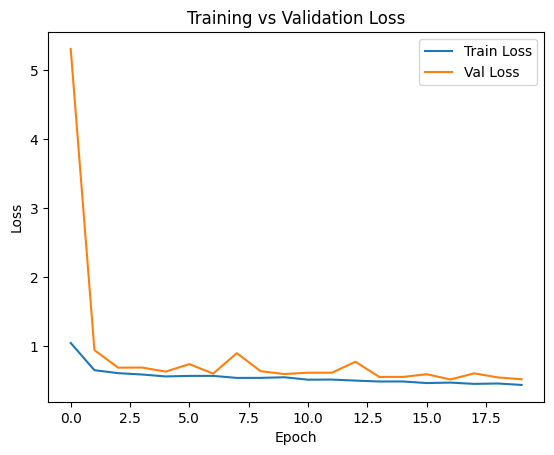

In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [14]:
model.save("unet_brain_mri_model.h5")
print("Model saved!")


Model saved!
